# Example: Frequency-domain noise removal

In the example below, we are going to first create a signal at a sampling rate of 1000Hz and duration 1 second that is the sum of two sinusoidals (at 50Hz and 120Hz respectively). Then add a lot of random noise to the signal. We are then going to use the Fourier Transform to remove noise.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, lfilter, filtfilt, freqz
import matplotlib

import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib notebook

# Set plot styles
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 8}) 
plt.rcParams.update({'lines.linewidth': 1})

In [3]:
# Simulation parameters
SAMPLING_RATE = 1000 # Hz 
DURATION = 1 # seconds

# Generate timestamp index
t = np.arange(0, DURATION, 1/SAMPLING_RATE)
index = pd.to_datetime(t, unit='s')

# Create clean signal 
f1 = 50 # Hz
f2 = 120 # Hz
y_clean = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)

# Add noise to create 3 noisy signals

We start by generating a clean underlying signal made up of two sinusoids at 50Hz and 120Hz. This will be our 'true' noise-free signal.

We then create three different noisy versions of this signal by adding different types of noise:

- Noisy signal 1 has high frequency noise above 200Hz. This is created by bandpass filtering white noise.
- Noisy signal 2 contains low frequency noise below 10Hz. This is created by lowpass filtering white noise.
- Noisy signal 3 has narrowband noise at 60Hz. This represents noise from power line interference.

So we now have 3 versions of the original clean signal with different noise profiles added. We will use these to test different filtering techniques.



In [4]:
# --- Add noise to create 3 noisy signals ---

# Generate white noise
noise1 = np.random.randn(len(t))
# Design high-pass filter 
b, a = butter(N=2, Wn=200/SAMPLING_RATE*2, btype='highpass')
# Filter to retain only >200Hz
noise1 = filtfilt(b, a, noise1) 
# Add to clean signal
y1 = y_clean + 5*noise1

# Noisy signal 2 - Low frequency noise <10 Hz
noise2 = 0.5*np.random.randn(len(t))  
b, a = butter(2, 10/SAMPLING_RATE*2, btype='lowpass') 
noise2 = lfilter(b, a, noise2)
y2 = y_clean + 5*noise2

# Noisy signal 3 - 60 Hz noise
noise3 = np.sin(2*np.pi*60*t) 
y3 = y_clean + noise3

# Create dataframe with timestamps
df = pd.DataFrame(index=index)
df['Clean'] = y_clean
df['Noisy1'] = y1
df['Noisy2'] = y2 
df['Noisy3'] = y3

<IPython.core.display.Javascript object>


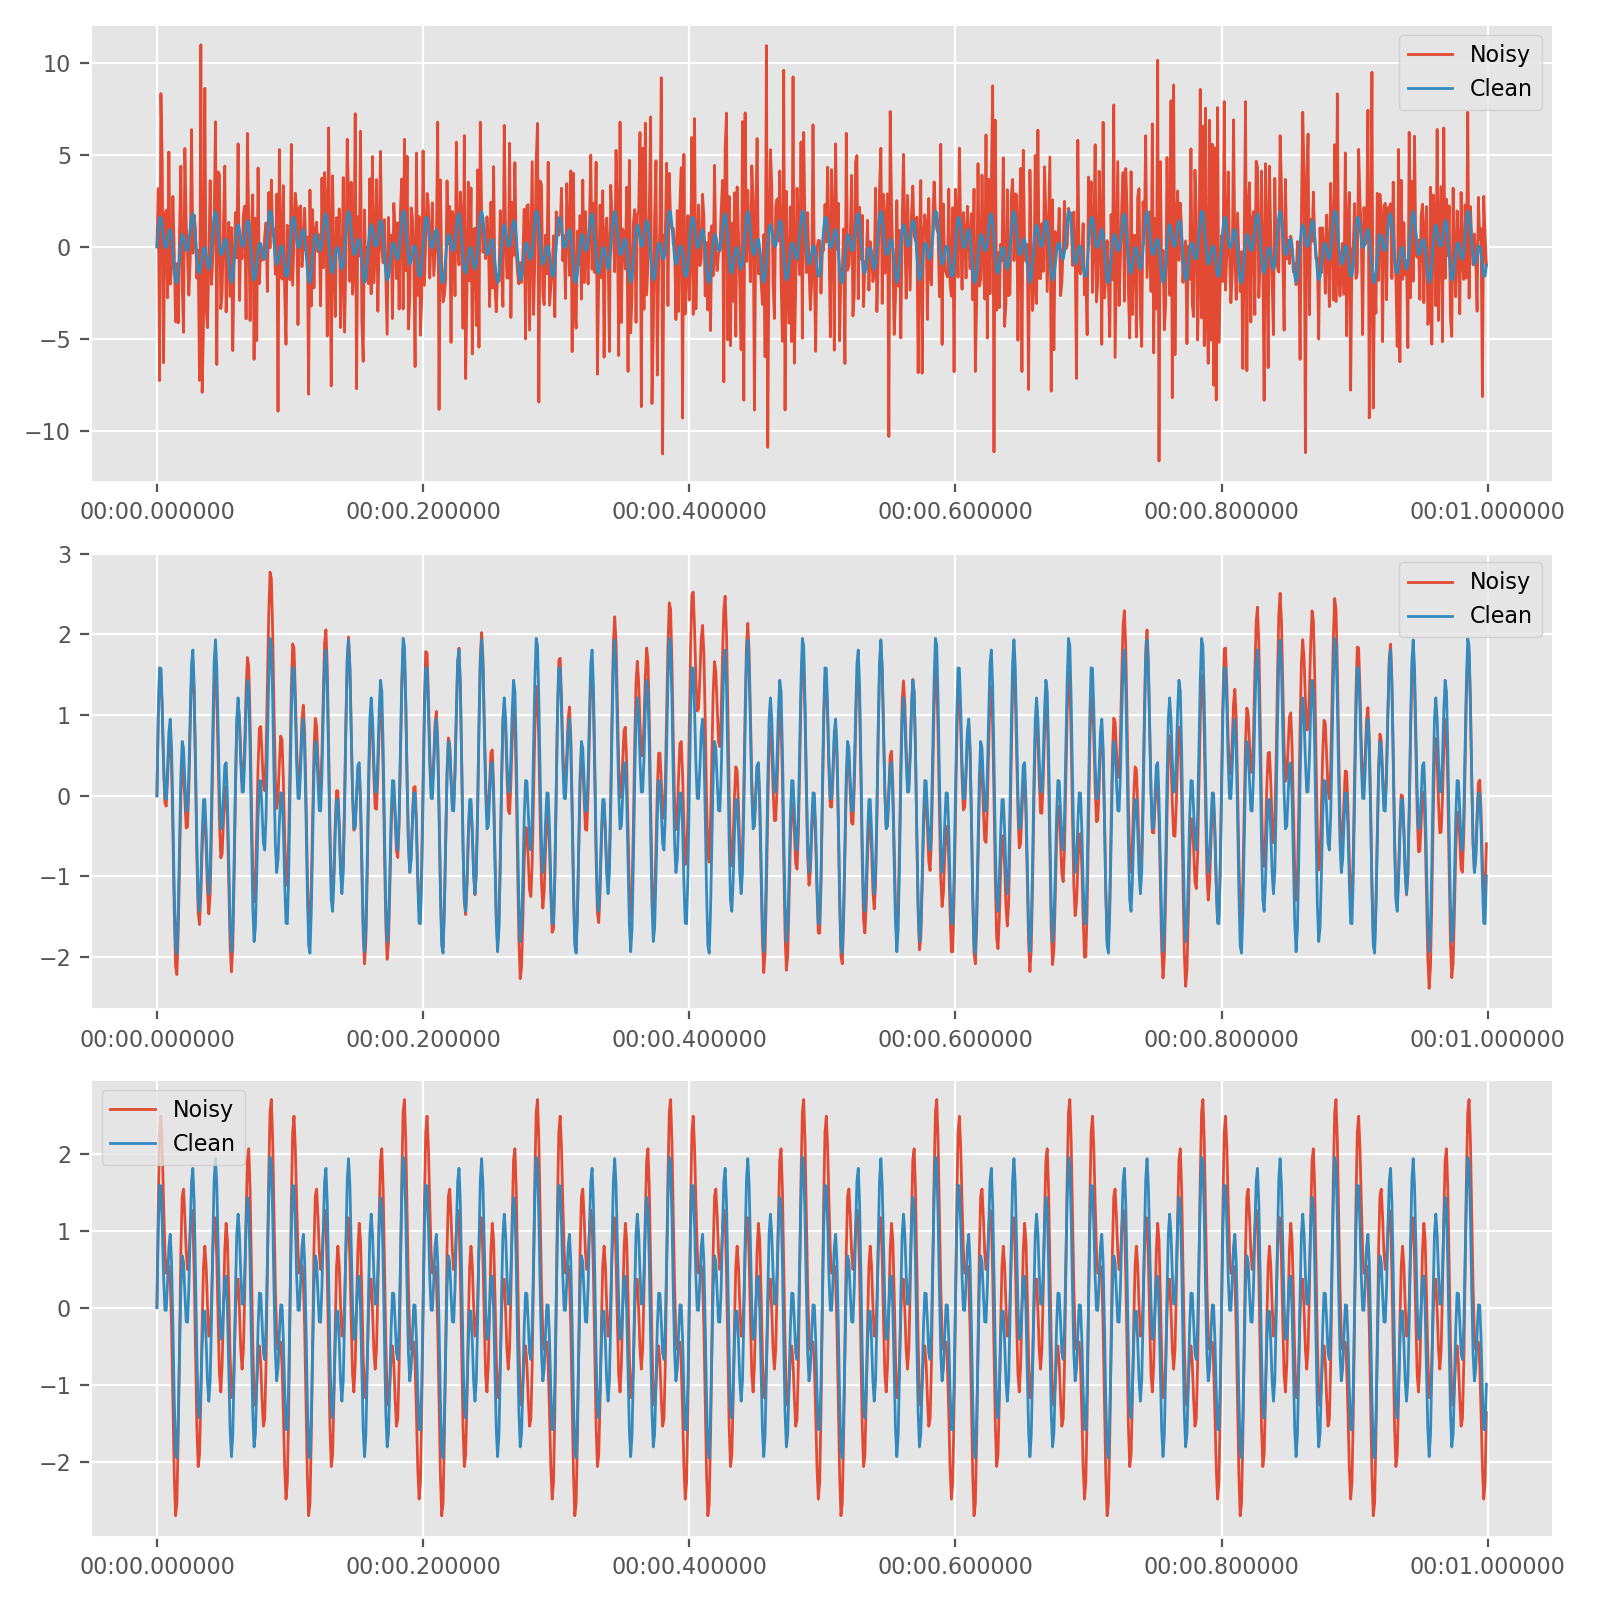

In [5]:
# Plot the noisy signals
fig, axes = plt.subplots(nrows=3, ncols=1)

for i, col in enumerate(['Noisy1', 'Noisy2', 'Noisy3']):
    ax = axes[i]
    ax.plot(df.index, df[col], label='Noisy')
    ax.plot(df.index, df['Clean'], label='Clean')
    ax.legend()

plt.tight_layout()
plt.show()

# Time domain filtering

Here we apply common time domain filters to the 3 noisy signals:

- Moving average smooths data by averaging over a rolling window. As the window size increases, more noise is removed but the signal is more smoothed.
- Exponential smoothing applies weighting exponents so that recent data has more influence. This retains features like peaks better than moving average.
- Median filter takes median over window, preserving edges better than smoothing filters.

We apply each of these filters with a window of 20 samples to all 3 noisy signals.

In [6]:
# --- Time domain filtering ---

# Apply filters
window = 20
df['MA1'] = df.Noisy1.rolling(window).mean()  
df['EMA1'] = df.Noisy1.ewm(span=window).mean()
df['Median1'] = df.Noisy1.rolling(window).median()

df['MA2'] = df.Noisy2.rolling(window).mean()
df['EMA2'] = df.Noisy2.ewm(span=window).mean() 
df['Median2'] = df.Noisy2.rolling(window).median()

df['MA3'] = df.Noisy3.rolling(window).mean()
df['EMA3'] = df.Noisy3.ewm(span=window).mean()
df['Median3'] = df.Noisy3.rolling(window).median()


# Plot filters on each noisy signal

This visualized the effect of the time domain filters on each noisy signal in the previous step. We can see how the different noise profiles are attenuated by the filters.

**We see that the three time domain filters don't perform well at all.**

<IPython.core.display.Javascript object>


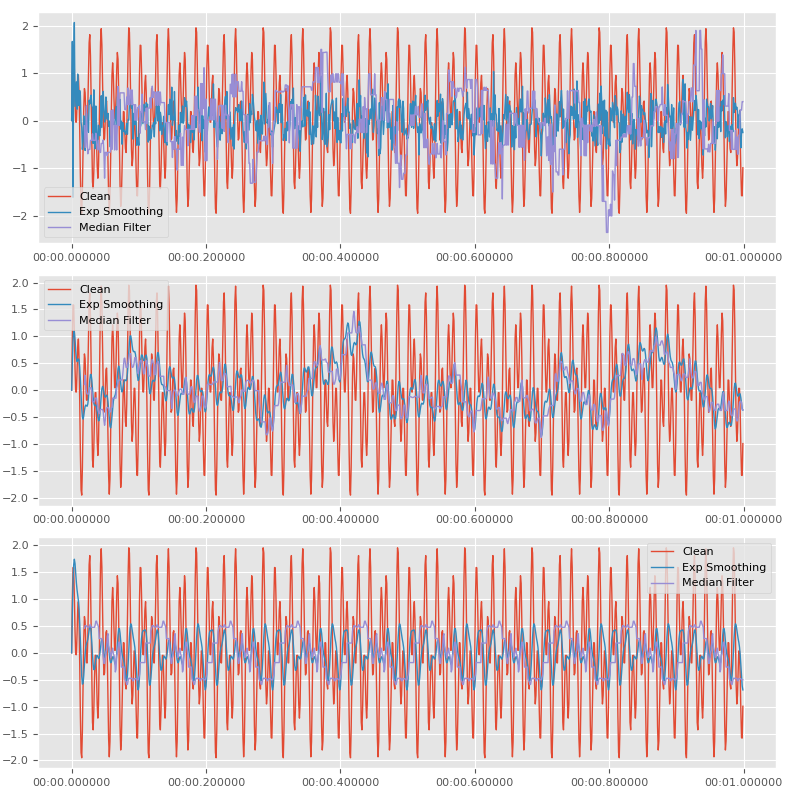

In [16]:
# Plot filters on each noisy signal
fig, axes = plt.subplots(nrows=3, ncols=1)

for i, col in enumerate(['Noisy1', 'Noisy2', 'Noisy3']):
    ax = axes[i]
#     ax.plot(df.index, df[col], label='Noisy')
    ax.plot(df.index, df['Clean'], label='Clean')
#     ax.plot(df.index, df['MA'+str(i+1)], label='Moving Avg') 
    ax.plot(df.index, df['EMA'+str(i+1)], label='Exp Smoothing')
    ax.plot(df.index, df['Median'+str(i+1)], label='Median Filter')
#     ax.set_title('Time Domain Filtering on Noisy Signal '+str(i+1))
    ax.legend()

plt.tight_layout()
plt.show()

# Frequency domain filtering

The Fast Fourier Transform (FFT) decomposes a signal into its frequency components. It tells us how much power is present at each frequency.

We take the FFT of the clean and 3 noisy signals. This will allow us to analyze the frequency content and design filters in the frequency domain.

In [8]:
# Take FFT
N = len(t)
f = rfftfreq(N, 1/SAMPLING_RATE)

Y_clean = rfft(df['Clean'].values, N)  
Y1 = rfft(df['Noisy1'].values, N)
Y2 = rfft(df['Noisy2'].values, N) 
Y3 = rfft(df['Noisy3'].values, N)


# Plot FFT spectrum

Here we visualize the FFT spectrum for each noisy signal. The peaks indicate the strength of the frequencies present.

We can clearly see the added noise profiles in each signal:

- Noisy 1 has high freq noise
- Noisy 2 has low freq noise
- Noisy 3 has 60Hz spike
The annotations highlight the noise versus true signal regions.


<IPython.core.display.Javascript object>


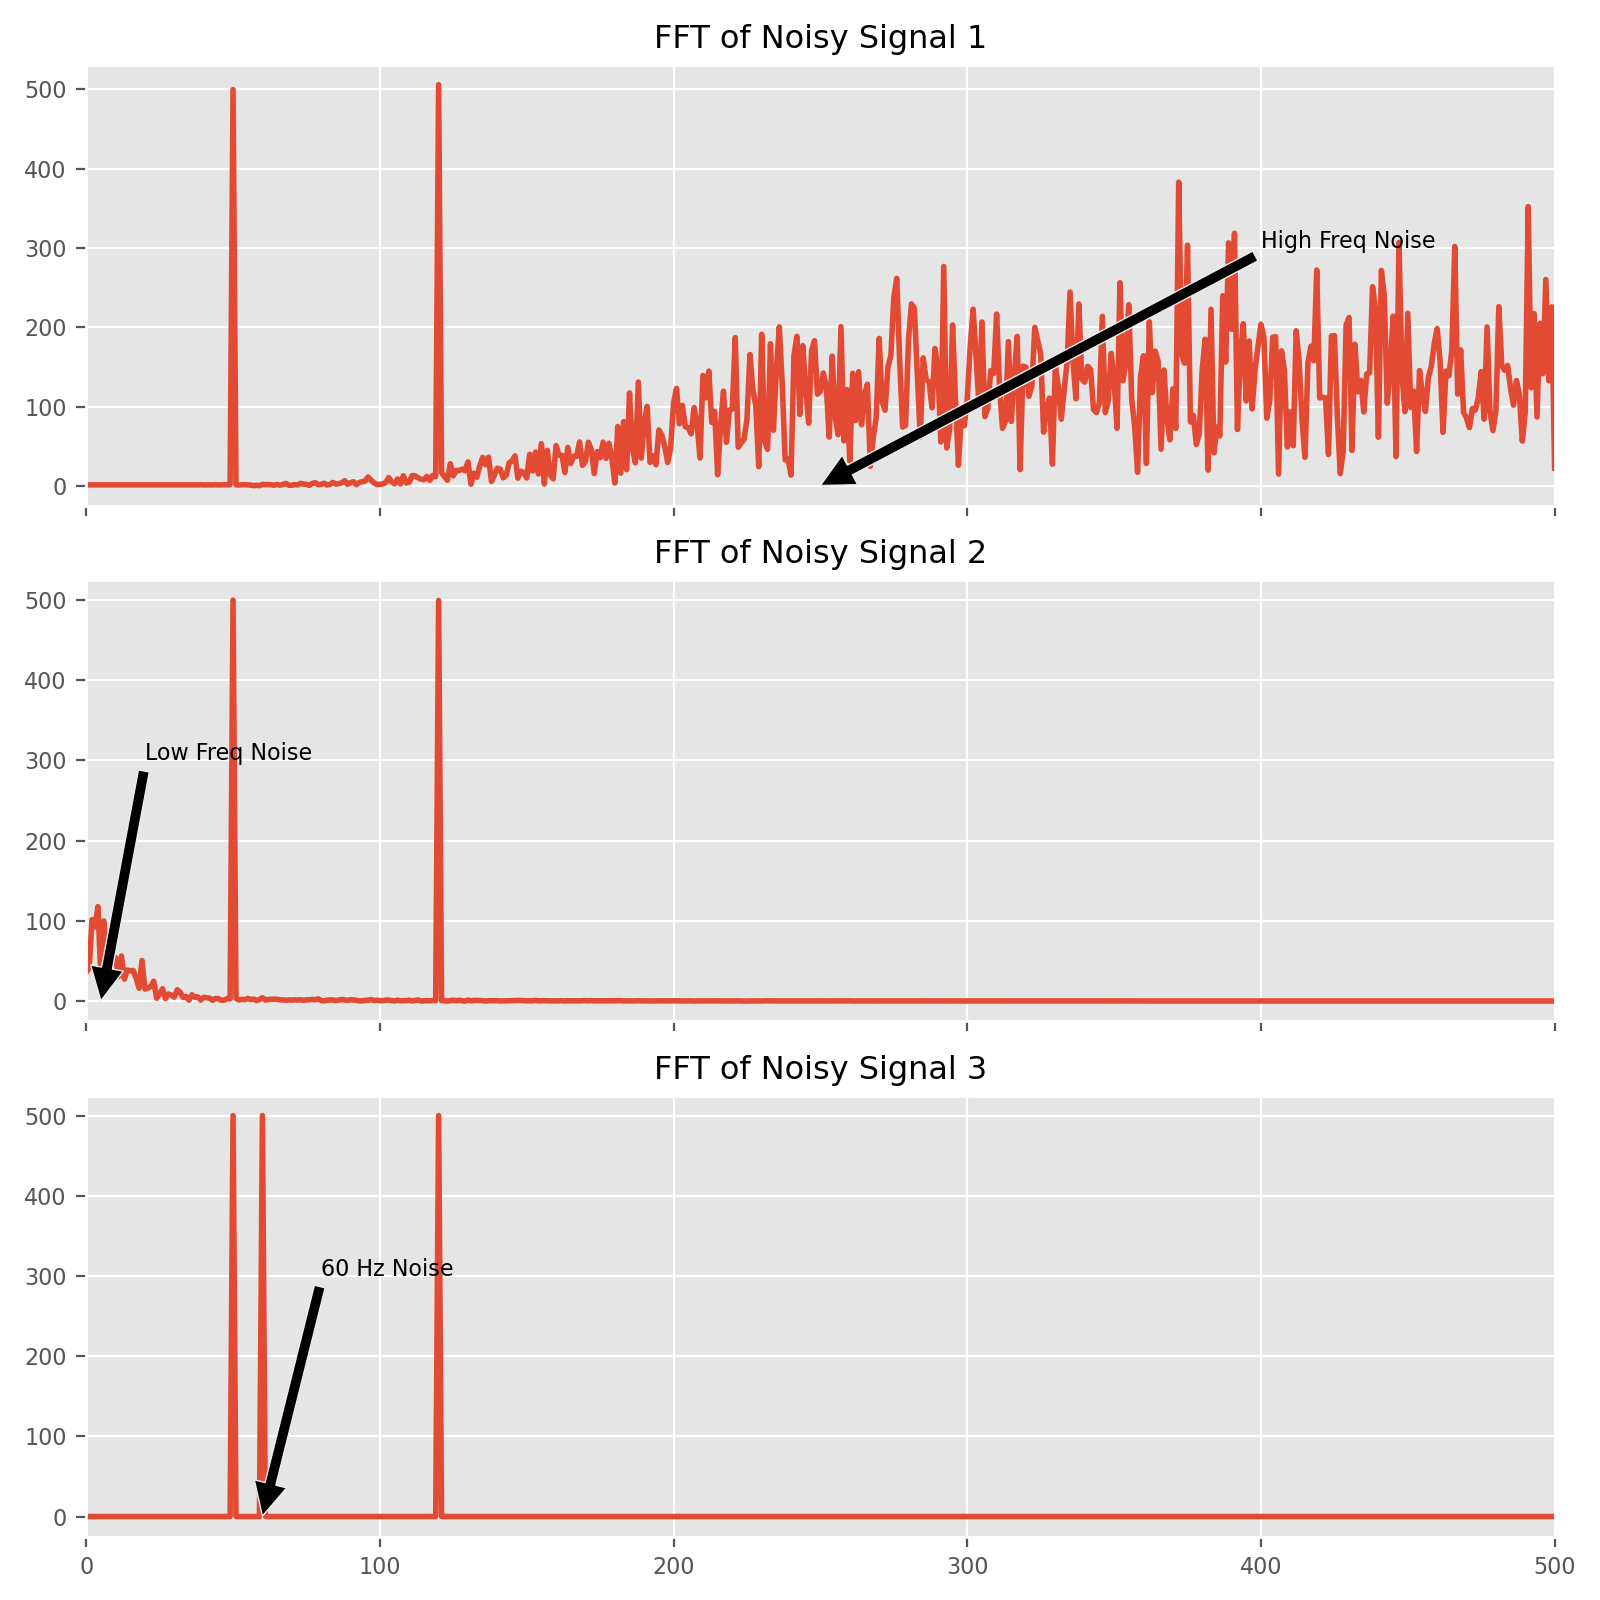

In [9]:
# Plot FFT spectrum
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)

for i, Y in enumerate([Y1, Y2, Y3]):
    ax = axes[i]
    ax.plot(f, np.abs(Y), linewidth=2)
    ax.set_xlim(0, SAMPLING_RATE/2)
    ax.set_title('FFT of Noisy Signal '+str(i+1))
    if i==0:
        ax.annotate('High Freq Noise', xy=(250, 0.4), xytext=(400, 300), arrowprops=dict(facecolor='black')) 
    if i==1:
        ax.annotate('Low Freq Noise', xy=(5, 0.4), xytext=(20, 300), arrowprops=dict(facecolor='black'))
    if i==2:  
        ax.annotate('60 Hz Noise', xy=(60, 0.4), xytext=(80, 300), arrowprops=dict(facecolor='black'))
        
plt.tight_layout()
plt.show()



# Create filters

Now that we have analyzed the frequency content, we design filters targeting each noise profile:

- Low pass filter to remove high frequencies
- High pass filter to remove low frequencies
- Bandstop filter to notch out 60Hz

The `butter` function from the `scipy.signal` package is a tool to design Butterworth filters. You don't need to know how exactly a Butterworth filter works except that is a commonly used filter since it doesn't introduce any ripples or oscillations in the signal it's filtering.

#### Key Parameters:

- **N (int)**: The order of the filter. Higher orders lead to steeper cutoff but it could introduce some distortions. Default is 5, so its ok to set it around this range.

- **Wn (array_like)**: Wn is the cutoff frequency divided by the Nyquist frequency, which is half of the sampling frequency. 
    - For low-pass and high-pass filters: it is the cutoff frequency.
    - For band-pass and band-stop filters: it is a two-element list of the lower and upper cutoff frequencies.

- **btype (str, optional)**: Type of the filter. Can be 'lowpass', 'highpass', 'bandpass', or 'bandstop'.


In [10]:
# set sample rate to 1kHz
SAMPLING_RATE = 1000 # Hz 

# calculate the Nyquist frequency
nyq = 0.5 * SAMPLING_RATE

# set order of the filter
order = 5

# Create filters 
b_high, a_high = butter(order, 130/nyq, btype='lowpass') # Low pass < 130 Hz
b_low, a_low = butter(order, 40/nyq, btype='highpass') # High pass > 40 Hz 
b_notch, a_notch = butter(order, [59/nyq, 61/nyq], btype='bandstop') # Notch at 60 Hz


<IPython.core.display.Javascript object>


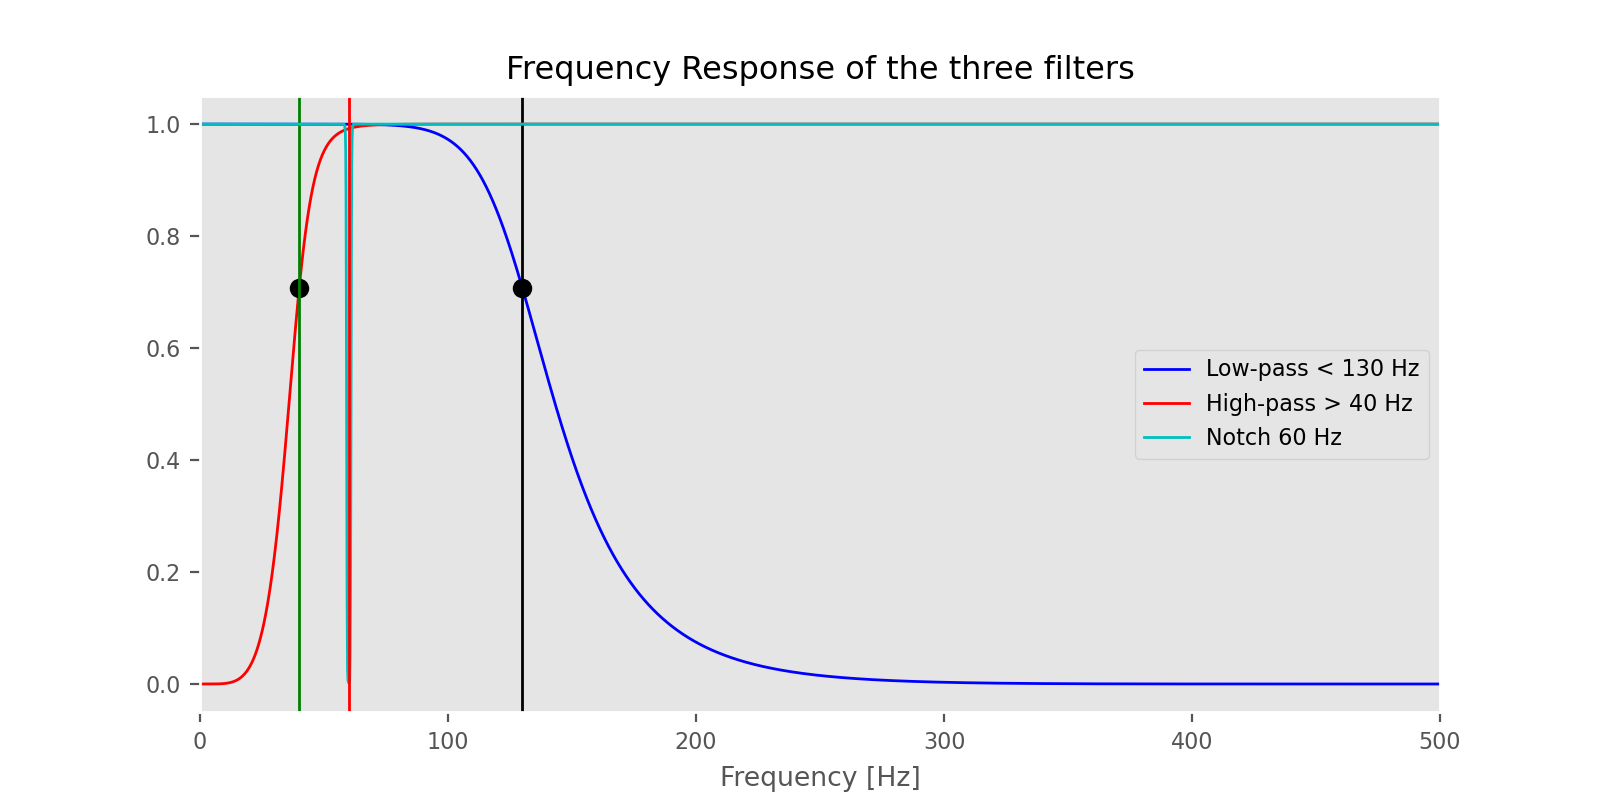

In [11]:
# Frequency response graph
w_high, h_high = freqz(b_high, a_high, worN=8000)
w_low, h_low = freqz(b_low, a_low, worN=8000)
w_notch, h_notch = freqz(b_notch, a_notch, worN=8000)

cutoff_high = 130
cutoff_low = 40
cutoff_notch = 60

plt.figure(figsize=(8,4))

plt.plot(0.5 * SAMPLING_RATE * w_high / np.pi, np.abs(h_high), 'b', label='Low-pass < 130 Hz')
plt.plot(cutoff_high, 0.5 * np.sqrt(2), 'ko')
plt.axvline(cutoff_high, color='k')
plt.xlim(0, 0.5 * SAMPLING_RATE)

plt.plot(0.5 * SAMPLING_RATE * w_low / np.pi, np.abs(h_low), 'r', label='High-pass > 40 Hz')
plt.plot(cutoff_low, 0.5 * np.sqrt(2), 'ko')
plt.axvline(cutoff_low, color='g')
plt.xlim(0, 0.5 * SAMPLING_RATE)

plt.plot(0.5 * SAMPLING_RATE * w_notch / np.pi, np.abs(h_notch), 'c', label='Notch 60 Hz')
plt.xlim(0, 0.5 * SAMPLING_RATE)
plt.axvline(cutoff_notch, color='r')
plt.xlim(0, 0.5 * SAMPLING_RATE)

plt.title('Frequency Response of the three filters')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.grid()
plt.show()

# Apply filters

We apply the filters designed in the previous step to the matching noisy signals:

- Low pass filter applied to Noisy Signal 1
- High pass filter applied to Noisy Signal 2
- Notch filter applied to Noisy Signal 3

This targets the noise specific to each signal.

#### Usage:

Once the filter is designed using the `butter` function, it can be applied to data using the `lfilter` function from the same package.

Here, `lfilter` takes the `b` and `a` coefficients of our filter and the data to be filtered. The output is the filtered data. For instance, `df.Noisy1` is filtered using the high-pass filter coefficients and the result is stored in a new column `HighPass1` of the dataframe `df`.

Remember that proper filter design requires understanding the nature of the noise and the desired signal. Improperly designed or applied filters might not only fail to remove noise but could potentially distort the desired signal.

In [12]:
# Apply filters 
df['HighPass1'] = lfilter(b_high, a_high, df.Noisy1)
df['LowPass2'] = lfilter(b_low, a_low, df.Noisy2)
df['Notch3'] = lfilter(b_notch, a_notch, df.Noisy3)



# Plot filtered signals

Here we visualize the result of the frequency domain filtering.

For each noise profile, we can see that the matching filter effectively attenuates the noise while preserving the original signal.

<IPython.core.display.Javascript object>


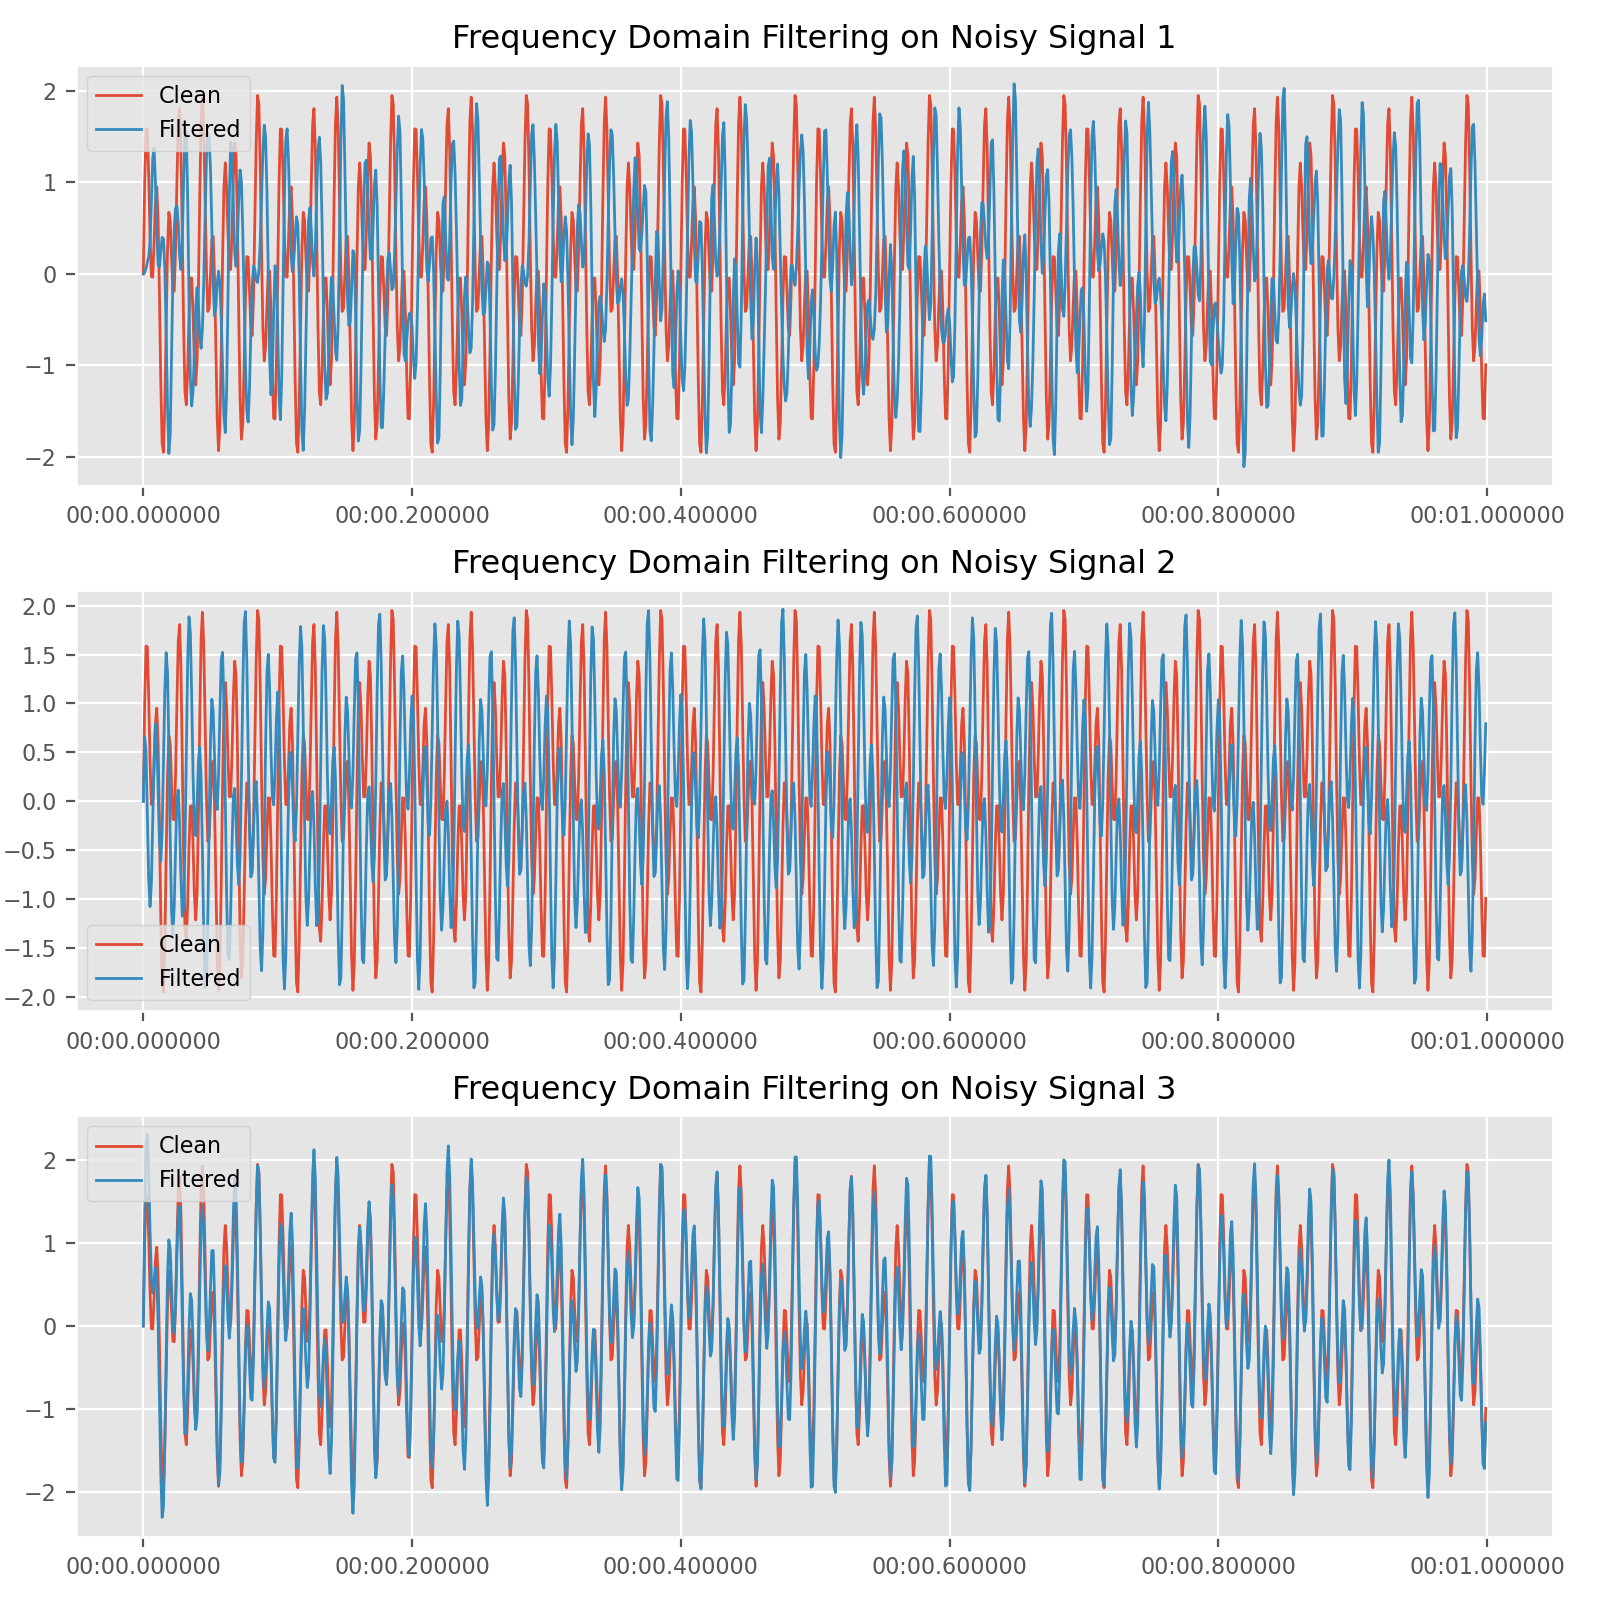

In [13]:
# Plot filtered signals
fig, axes = plt.subplots(nrows=3, ncols=1)

for i, col in enumerate([['Noisy1', 'HighPass1'], ['Noisy2', 'LowPass2'], ['Noisy3', 'Notch3']]):
    ax = axes[i]
    ax.plot(df.index, df['Clean'], label='Clean')
#     ax.plot(df.index, df[col[0]], label='Noisy')
    ax.plot(df.index, df[col[1]], label='Filtered')
    ax.set_title('Frequency Domain Filtering on Noisy Signal '+str(i+1))
    ax.legend()
    
plt.tight_layout()
plt.show()